Finding locations for business expansion - building a propensity model for climbing wall users
====
----

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# header
%matplotlib inline
sns.set_theme()

data_path='data/'

# 1. Executive summary

An international climbing wall chain wants to find locations for five new premises to expand on the Polish market. They want to determine users propensity for a long-term subscription based on sociodemographical data.

I decide to develop a simple logistic regression model to maximize interpretability. It allows to determine key propensity drivers and provide actionable recommendations. Precision is used as success metrics to ensure optimized resources dedication.

I identify the profile of users with high propensity scores. It corresponds to a person with 'optimal' social activity, single, male, and living in a big city (500k+). Some of the interesting observations include:
* around 50% of single users declare interest in long-term subscription
* 'optimal' social activity means having 100-250 friends, and interest in subscription in this group is five times higher than in the remaining group.

Big cities exhibit high potential benefits due to the higher propensity scores and population potential. I recommend the approach below.
* Consider locations in 500k+ cities, which correspond to: Warszawa, Krakow, Wroclaw, Lodz, Poznan.
* Focus on districts which are preferred by people with the profile identified above. Perform local market research if needed.

---
# 2. Business challenge and approach

## Business challenge

A popular climbing wall chain wants to find locations for five new premises to expand on the Polish market. They need a predictive model to predict propensity of a user for a long-term subscription. A dataset containing this information along with features representing socio-domegraphics, location and users interests is provied.

I define the goals of the project below.
* Develop a ML model to predict users propensity based on available features.
* Use precision as success metrics.
* Find main propensity drivers and make recommendation for the premises location.

Precision is used as a success metrics, to maximize the proportion of users predicted as potential subscribers that actually show interest in the subscription. This fosters the determiniation of key propensity drivers and dedicating resources (new locations, more in-depth local research) to the most promising users groups and locations.

## Approach
The main objective of this project is to provide actionable insights for the business decision-making. Therefore, the model interpretability is a crucial factor. I focus on a simple model (logistic regression) and data exploration to create meaningful categories that can be easily interpreted. Since the test data does not contain the target variable, I split the training dataset to get a validation sample.

The data transformations, exploratory data analysis and feature engineering are described in detail in section 'Input and data transformations'. The report continues with sections on model building and quality assessment. I conclude with sections 'Findings and recommendations' and 'Limitations of the approach'.

---
# 3. Input data and transformations

## Input data and feature candidates
* Dataset containing features representing socio-domegraphics, location, user interests, and the target varialbe (interest in a long-term subscription).
* Data on 4k users in the training sample and 2k in the test sample (no target variable available). The training dataset is split into training (3.2k users) and validation datasets (0.8k users). All of the missing data is retrieved, and full available samples are used in the model building and validation process.

I start with loading and exploring the dataset (data types, features, missing values).

In [2]:
# load data
# ! keep user_id as it is needed in the scored output file
# ? add also JSON file 
# need to merge/join relevant dataframes from CSV and JSON files based on user ID
# not for now: hobbies & interest groups not used as features; they could be used to improve model performance; feature: flag that someone is onterested in sports based on keywords in hobbies/interest groups

df_train = pd.read_csv(data_path+"train.csv")
df_test = pd.read_csv(data_path+"test.csv")

# keep them in a single list to ensure consistent processing
dfs = [df_train, df_test]

In [3]:
# explore data: quick view (data types / missing values / duplicates)
for df in dfs:   
    # print(df_train.head())
    print(df.info())
    print("\n")
    
    # check for duplicates
    print("Number of duplicate rows:", df.duplicated().sum())
    print("\n")

# check if balanced
print(df_train["target"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   4000 non-null   int64  
 1   target                    4000 non-null   int64  
 2   name                      3982 non-null   object 
 3   sex                       3616 non-null   object 
 4   dob                       3606 non-null   object 
 5   location                  4000 non-null   object 
 6   location_population       4000 non-null   int64  
 7   location_from             4000 non-null   object 
 8   location_from_population  4000 non-null   int64  
 9   occupation                4000 non-null   object 
 10  hobbies                   3320 non-null   object 
 11  daily_commute             3595 non-null   float64
 12  friends_number            4000 non-null   int64  
 13  relationship_status       3607 non-null   object 
 14  educatio

Some of the features in the dataset might be good predictors of the subscription. They are related to users basic demographic information and lifestyle (social activity and mobility):
* demographics: sex, date of birth (age), education, location_population
* lifestyle: relationship_status, friends_number, daily_commute
* interests: occupation, hobbies, interest groups.

The first two groups seem relevant to train the model and I focus on them. The last group could probably be used to improve model's performance if it is not satisfactory.

The dataset is unbalanced, with only 20% of the training sample corresponding to potential subscribers.

In [4]:
# candidates for features used to train the model
# ! "name" kept only to retrieve missing information in "sex"
features_candidates = ["sex", "dob", "location_population", "relationship_status", "education", "friends_number", "daily_commute", "target", "name"]

for i in range(len(dfs)):
    dfs[i] = dfs[i][features_candidates]

for df in dfs:
    print(df.info())
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  3616 non-null   object 
 1   dob                  3606 non-null   object 
 2   location_population  4000 non-null   int64  
 3   relationship_status  3607 non-null   object 
 4   education            3592 non-null   float64
 5   friends_number       4000 non-null   int64  
 6   daily_commute        3595 non-null   float64
 7   target               4000 non-null   int64  
 8   name                 3982 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 281.4+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  1809 non-null   object 
 1   dob         

## Data transformations

Data transformations are performed in several stages. I will go through these points for each of the candidate features one by one.

#### Data wrangling
In this step, I inspect available data and transform it into most usable formats. I create meaningful categories and derive new features. Some of the transformations are listed below.
* Supplementing missing data in "sex" column using "name".
* Tranforming "date of birth" into "age" intervals.

In [5]:
# sex
# ! categorical -> encode
# ? NaN: derive missing values from name (done)

# check unique values
for df in dfs:
    print(df["sex"].value_counts(dropna=False))
    print("\n")

sex
female    2040
male      1576
NaN        384
Name: count, dtype: int64


sex
female    1019
male       790
NaN        191
Name: count, dtype: int64




In [6]:
# sex
   
# derive missing value directly from the "name" column 
for df in dfs:
    # check for missing values
    print(df["sex"].isnull().sum())
    print("\n")

    def sex_from_name(name):
        # don't derive information from NaN values
        if pd.isnull(name):
            return name
        # female names end with 'a' and male ones do not
        else:
            return "female" if name.endswith("a") else "male"
    
    # apply to missing data in the "sex" column
    df.loc[df["sex"].isnull(), "sex"] = df["name"].apply(sex_from_name)

    # can drop the "name" column now
    df.drop("name", axis = 1, inplace = True)

    # check for missing values
    print(df["sex"].isnull().sum())
    print("\n")

384


1


191


2




C:\Users\malec\AppData\Local\Temp\ipykernel_33064\3891541197.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("name", axis = 1, inplace = True)
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\3891541197.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("name", axis = 1, inplace = True)


In [7]:
# dob
# ! transform into age / meaningful intervals -> ordinal
# ? NaN: ? median

for df in dfs:
    # check unique values
    print(df["dob"].value_counts(dropna=False))
    print("\n")

    # strip year (for not null only)
    df.loc[df["dob"].notnull(), "dob"] = df.loc[df["dob"].notnull(), "dob"].str.split("-").str[0].astype(int)

    # transform into age (for not null only)
    # ! assumes current year: 2024
    current_year = 2024
    df.loc[df["dob"].notnull(), "dob"] = current_year - df.loc[df["dob"].notnull(), "dob"]
    df.rename(columns={"dob": "age"}, inplace=True) # rename to give a meaning

    # check unique values (age)
    print(df["age"].value_counts(dropna=False))
    print("\n")

dob
NaN           394
2000-03-20      4
1988-07-05      3
1971-09-07      3
1995-02-16      3
             ... 
1996-10-28      1
1979-06-19      1
1979-04-19      1
1958-03-04      1
1998-09-02      1
Name: count, Length: 3243, dtype: int64


age
NaN      394
24.0     187
25.0     117
46.0     108
48.0     107
        ... 
97.0       1
102.0      1
89.0       1
91.0       1
87.0       1
Name: count, Length: 71, dtype: int64


dob
NaN           191
1968-01-12      3
1975-10-11      3
1985-07-17      2
2000-03-17      2
             ... 
1976-11-27      1
1963-06-09      1
1986-09-15      1
1969-10-20      1
1982-10-25      1
Name: count, Length: 1710, dtype: int64


age
NaN     191
24.0     87
25.0     59
44.0     57
50.0     54
       ... 
93.0      1
87.0      1
22.0      1
85.0      1
92.0      1
Name: count, Length: 71, dtype: int64




C:\Users\malec\AppData\Local\Temp\ipykernel_33064\1785966667.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"dob": "age"}, inplace=True) # rename to give a meaning
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\1785966667.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"dob": "age"}, inplace=True) # rename to give a meaning


count     3606
unique      70
top         24
freq       187
Name: age, dtype: int64
count     1809
unique      70
top         24
freq        87
Name: age, dtype: int64


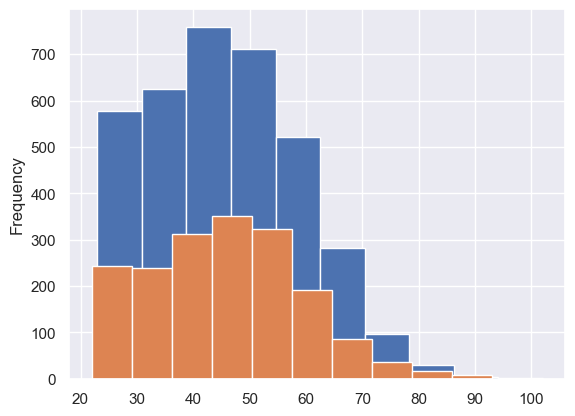

In [8]:
# age

# get basic characteristics
for df in dfs:
    print(df["age"].describe())
    df["age"].plot.hist()

age
3.0    1145
0.0     872
2.0     844
1.0     744
NaN     395
Name: count, dtype: int64
age
3.0    593
2.0    418
0.0    412
1.0    386
NaN    191
Name: count, dtype: int64


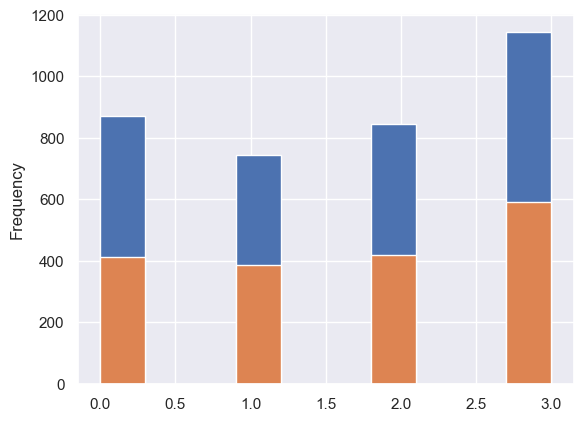

In [9]:
# age

# define intervals based on age distribution
age_intervals = [20, 30, 40, 50, 100]
age_labels = ["20s", "30s", "40s", "50+"] # just for plotting

for df in dfs:
    # create ordinal variable
    df.loc[:,"age"] = pd.cut(df["age"], bins=age_intervals, labels=False, include_lowest=True)

    # get basic characteristics
    print(df["age"].value_counts(dropna=False))
    df["age"].plot.hist()

count    4.000000e+03
mean     3.105877e+05
std      4.878360e+05
min      7.860000e+02
25%      2.435725e+04
50%      8.007200e+04
75%      3.523130e+05
max      1.764615e+06
Name: location_population, dtype: float64
count    2.000000e+03
mean     3.336566e+05
std      5.114764e+05
min      9.920000e+02
25%      2.609200e+04
50%      9.562900e+04
75%      4.038830e+05
max      1.764615e+06
Name: location_population, dtype: float64


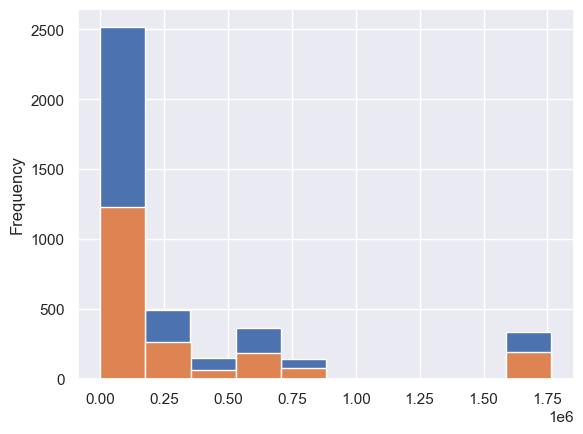

In [10]:
# location_population
# ! meaningful intervals -> ordinal
# ? NaN: OK

for df in dfs:
    # get basic characteristics
    print(df["location_population"].describe())
    df["location_population"].plot.hist()
    # df["location_population"].plot.hist(range=(0,1e5))
   

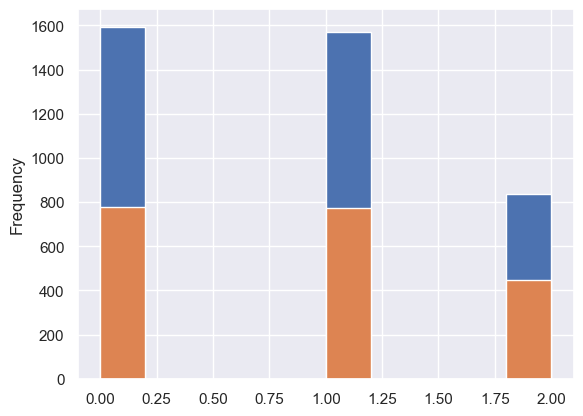

In [11]:
# location_population

# define intervals based on population distribution
population_intervals = [0, 0.05e6, 0.5e6, 2.0e6]
population_labels = ["small", "middle", "big"] # just for plotting

for df in dfs:
    # create ordinal variable
    df.loc[:,"location_population"] = pd.cut(df["location_population"], bins=population_intervals, labels=False, include_lowest=True)

    # get basic characteristics
    df["location_population"].plot.hist()

education
4.0    1065
3.0     765
5.0     755
2.0     504
NaN     408
6.0     269
1.0     234
Name: count, dtype: int64


education
4.0    537
3.0    385
5.0    370
2.0    249
NaN    183
6.0    139
1.0    137
Name: count, dtype: int64




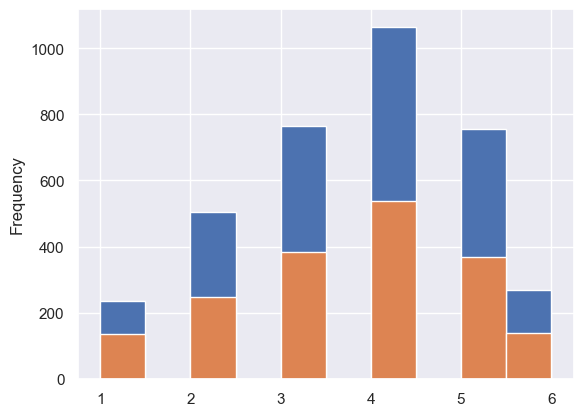

In [12]:
# education
# ! ordinal
# ? NaN: median

for df in dfs:
    # check unique values
    print(df["education"].value_counts(dropna=False))
    df["education"].plot.hist()
    print("\n")

count    4000.000000
mean      199.877750
std        90.494937
min         0.000000
25%       143.000000
50%       199.000000
75%       256.000000
max       619.000000
Name: friends_number, dtype: float64
friends_number
0      75
230    29
174    27
191    26
224    26
       ..
366     1
488     1
393     1
9       1
344     1
Name: count, Length: 438, dtype: int64


count    2000.00000
mean      199.95200
std        89.91402
min         0.00000
25%       144.00000
50%       199.00000
75%       254.00000
max       543.00000
Name: friends_number, dtype: float64
friends_number
0      41
198    20
199    20
187    18
184    16
       ..
12      1
326     1
431     1
448     1
379     1
Name: count, Length: 400, dtype: int64




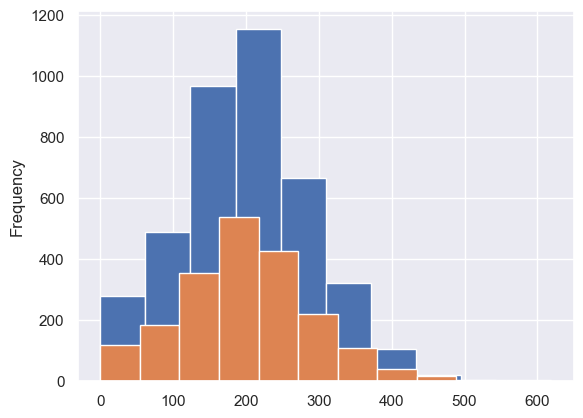

In [13]:
# friends_number
# ! meaningful intervals -> ordinal
# ? NaN: 0 looks like a suspicious value here - it can indicate a missing value, but also an actual group of users with 'no friends'
# ? for now I assume case 2 (specific group of users)

for df in dfs:
    # check unique values
    print(df["friends_number"].describe())
    print(df["friends_number"].value_counts(dropna=False))
    df["friends_number"].plot.hist()
    # df["friends_number"].plot.hist(range=(0,10))
    print("\n")

friends_number
4    1075
2     943
3     888
1     553
0     541
Name: count, dtype: int64
friends_number
4    522
2    464
3    459
1    295
0    260
Name: count, dtype: int64


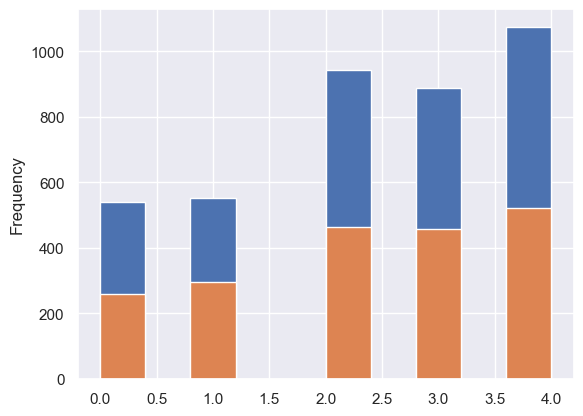

In [14]:
# friends_number

# define intervals based on friends_number distribution
friends_intervals = [0, 100, 150, 200, 250, 1000]

for df in dfs:
    # create ordinal variable
    df.loc[:,"friends_number"] = pd.cut(df["friends_number"], bins=friends_intervals, labels=False, include_lowest=True)

    # get basic characteristics
    print(df["friends_number"].value_counts(dropna=False))
    df["friends_number"].plot.hist()

count    3595.000000
mean       50.098748
std        28.806060
min         0.000000
25%        25.000000
50%        50.000000
75%        75.000000
max        99.000000
Name: daily_commute, dtype: float64


count    1796.000000
mean       49.928731
std        28.881555
min         0.000000
25%        26.000000
50%        49.000000
75%        75.000000
max        99.000000
Name: daily_commute, dtype: float64




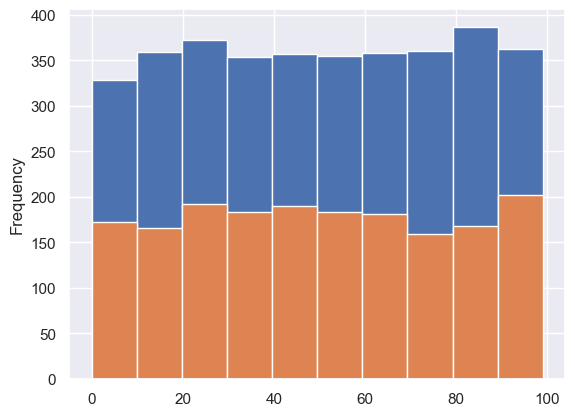

In [15]:
# "daily_commute"
# ! meaningful intervals -> ordinal
# ? NaN: mode

for df in dfs:
    # check unique values
    print(df["daily_commute"].describe())
    # print(df["daily_commute"].value_counts(dropna=False))
    df["daily_commute"].plot.hist()
    print("\n")

daily_commute
1.0    732
3.0    725
0.0    725
4.0    712
2.0    701
NaN    405
Name: count, dtype: int64
daily_commute
1.0    376
2.0    365
0.0    360
4.0    353
3.0    342
NaN    204
Name: count, dtype: int64


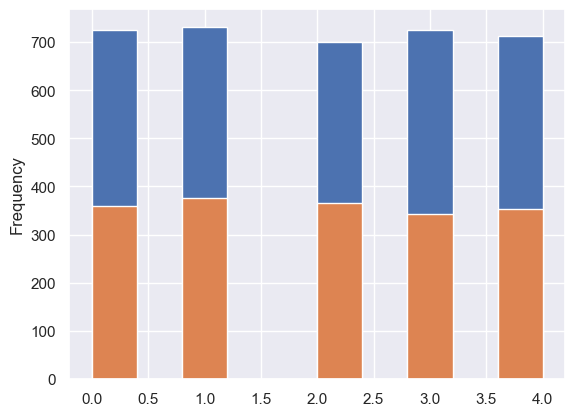

In [16]:
# daily_commute

# define intervals based on daily_commute distribution
commute_intervals = [0, 20, 40, 60, 80, 100]

for df in dfs:
    # create ordinal variable
    df.loc[:,"daily_commute"] = pd.cut(df["daily_commute"], bins=commute_intervals, labels=False, include_lowest=True)

    # get basic characteristics
    print(df["daily_commute"].value_counts(dropna=False))
    df["daily_commute"].plot.hist()

relationship_status
In relationship      1247
Married               830
Married with kids     749
Single                585
NaN                   393
Divorced              196
Name: count, dtype: int64


relationship_status
In relationship      597
Married              425
Married with kids    363
Single               304
NaN                  230
Divorced              81
Name: count, dtype: int64




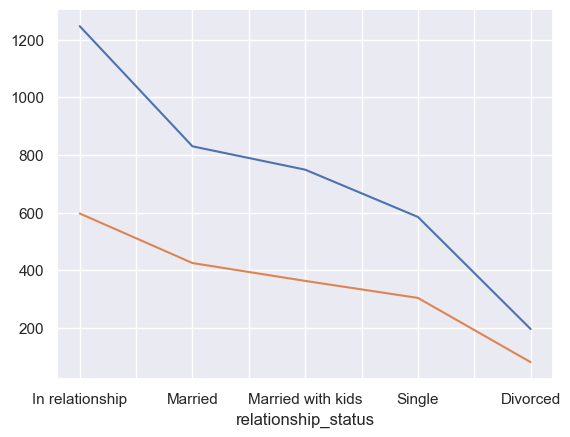

In [17]:
# relationship status
# ! categorical -> encode
# ? NaN: mode

for df in dfs:
    # check unique values
    print(df["relationship_status"].value_counts(dropna=False))
    df["relationship_status"].value_counts().plot()
    print("\n")


#### Exploratory data analysis

The initial feature candidates are now transformed into forms that can be more informative in this study (meaningful categories, derived values).

I perform exploratory data analysis on these cleaned features.

First, I investigate the fractions of users interested in the subscription in various categories.

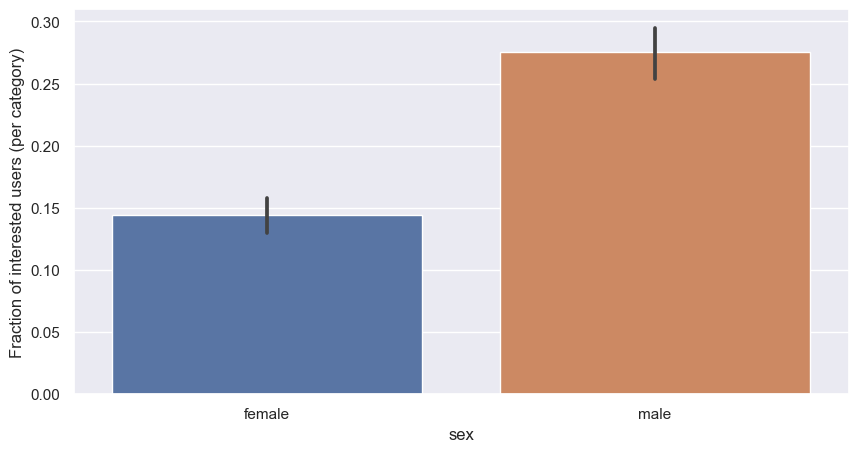

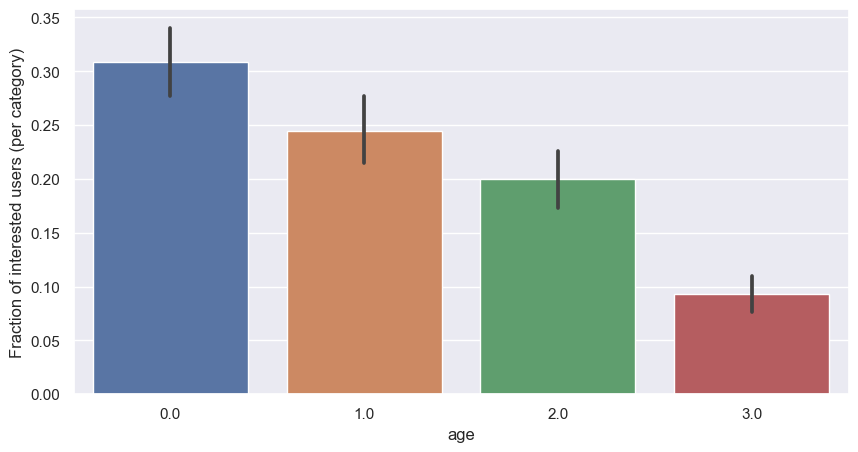

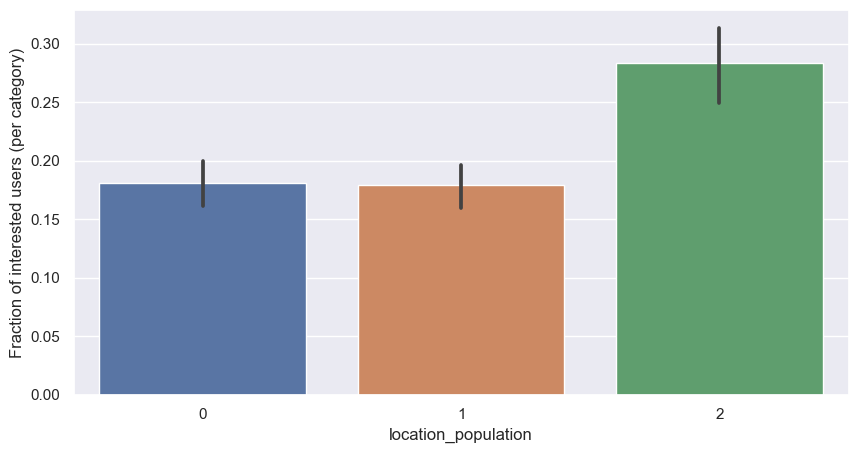

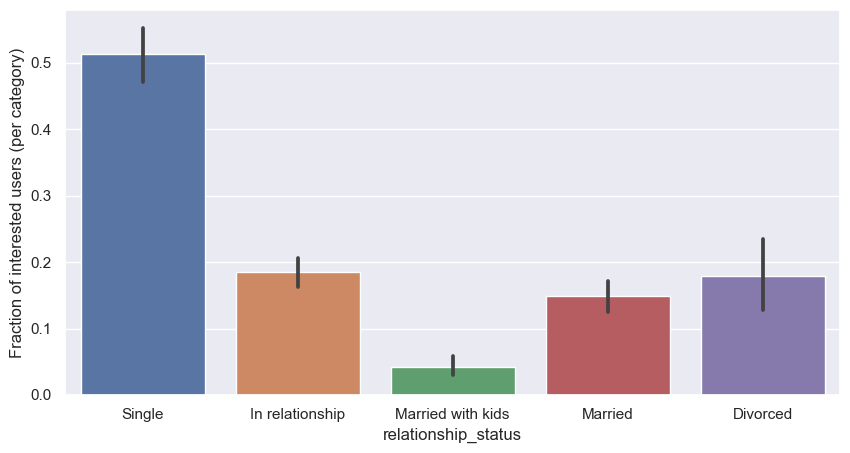

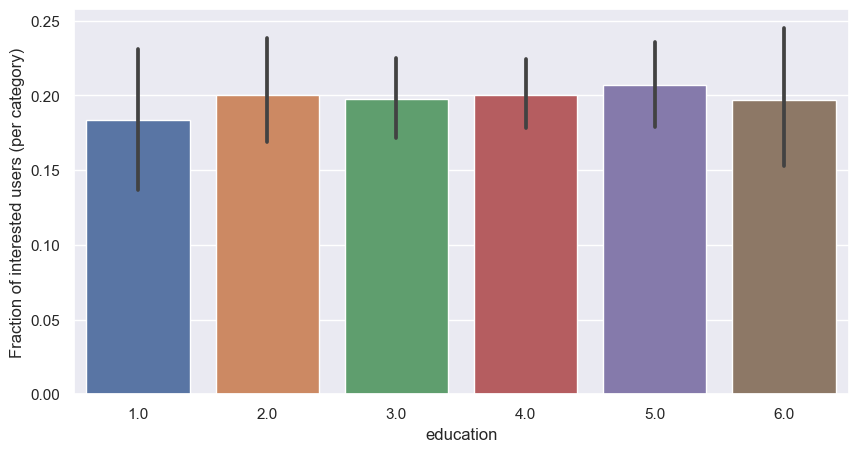

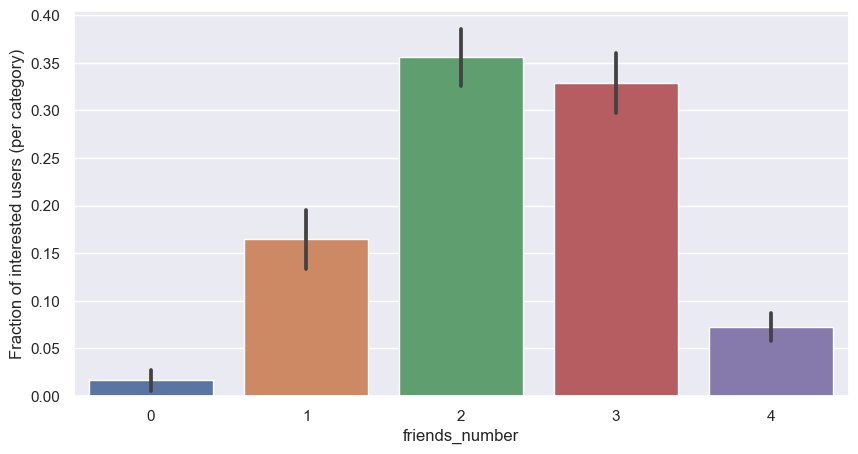

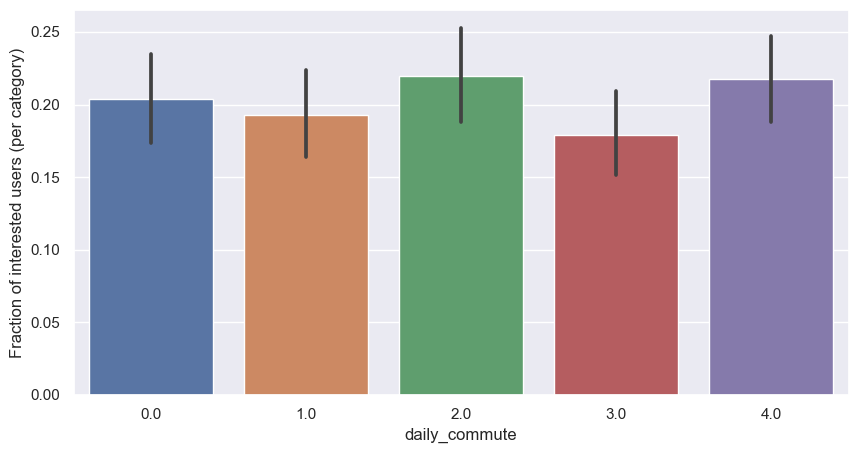

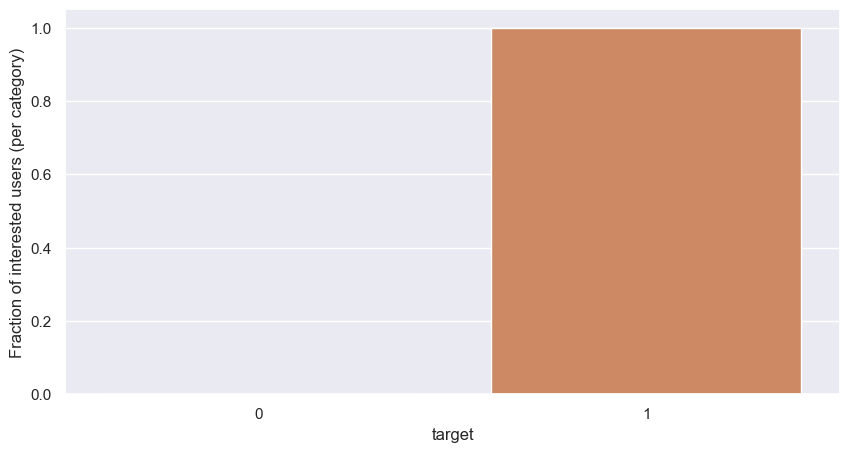

In [18]:
features_cleaned = ["sex", "age", "location_population", "relationship_status", "education", "friends_number", "daily_commute", "target"]

# ! exploratory analysis done for the training dataset only (similar feature distributions in the test dataset)

for feature in features_cleaned:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=dfs[0], x=feature, y="target")
    plt.ylabel("Fraction of interested users (per category)")
    plt.show()

Observations on the fraction of users showing interest in the subscription in various categories.
* Sex: in the males category, fraction almost two times higher than in the females category.
* Age: fraction of potential users decreases with age.
* Population: fraction of potential user higher in locations with big population.
* Relationship status: plays an important role. Almost 50% of singles declare interest in the subscription, while for married with kids it is only 3%.
* Number of friends: potential subscriptions grouped in range 100-250. People with less or more friends than declare interest in the subscription less frequently.

No strong patterns observed in education and daily commute categories.

Based on the above observations, I replace the 'number of friends' feature with a new one, representing 'optimal social activity' (corresponds to having friends in range 100-250).

C:\Users\malec\AppData\Local\Temp\ipykernel_33064\4138643869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"social_activity_opt"] = df["friends_number"].apply(lambda friends: 1 if friends in opt_range else 0)
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\4138643869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"social_activity_opt"] = df["friends_number"].apply(lambda friends: 1 if friends in opt_range else 0)


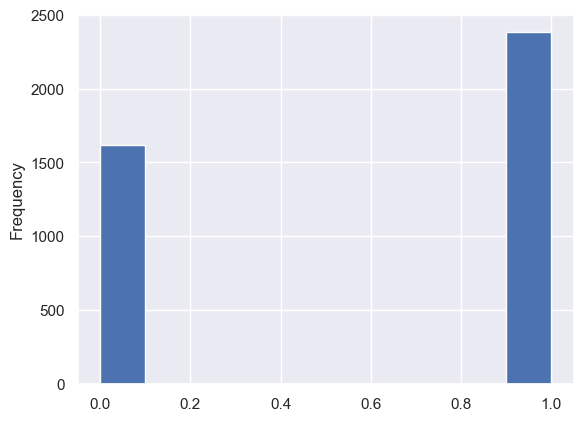

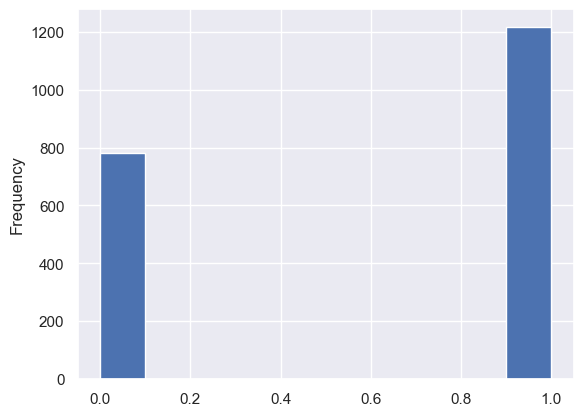

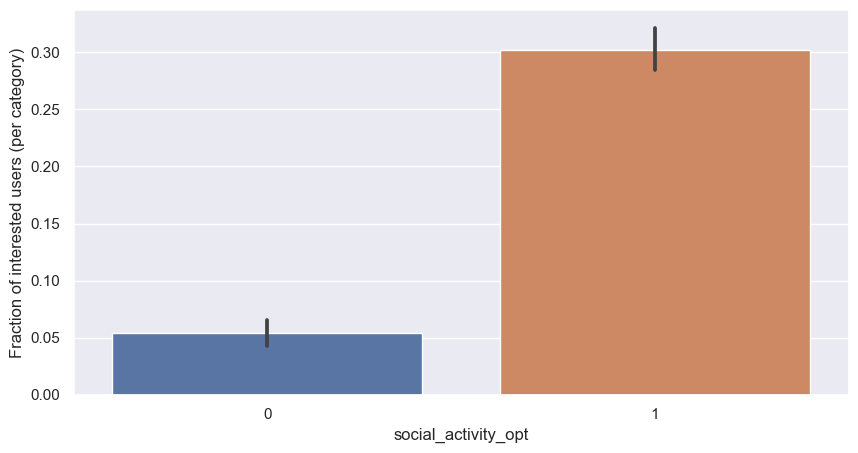

['sex', 'age', 'location_population', 'relationship_status', 'education', 'daily_commute', 'target', 'social_activity_opt']


C:\Users\malec\AppData\Local\Temp\ipykernel_33064\4138643869.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("friends_number", axis=1, inplace=True)
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\4138643869.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("friends_number", axis=1, inplace=True)


In [19]:
# derive new variable from the friends_numbers column
# ! social_activity_opt: 0 out of range / 1 in range [1, 2, 3]
# ! binary -> one-hot encoded
opt_range = [1, 2, 3]

for df in dfs:
    df.loc[:,"social_activity_opt"] = df["friends_number"].apply(lambda friends: 1 if friends in opt_range else 0)

# inspect the new feature
for df in dfs:
    df["social_activity_opt"].plot.hist()
    plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=dfs[0], x="social_activity_opt", y="target")
plt.ylabel("Fraction of interested users (per category)")
plt.show()

# drop old feature / update features_cleaned
for df in dfs:
    df.drop("friends_number", axis=1, inplace=True)

features_cleaned.remove("friends_number")
features_cleaned.append("social_activity_opt")
print(features_cleaned)

As a final step in EDA, I investigate correlations in the dataset.

Features do not seem to be correlated with each other.

Location population shows a weak positive correlation with the target variable (together with stronger ones from social_activity_opt), which indicates that these features may be good predictors for the user subscription.

In [20]:
# check correlations
# ! exploratory analysis done for the training dataset only (similar feature distributions in the test dataset)

# calculate for numerical columns only
print(dfs[0].info())
correlations = dfs[0].select_dtypes(include=['number']).corr()
print(correlations.round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  3999 non-null   object 
 1   age                  3605 non-null   object 
 2   location_population  4000 non-null   int64  
 3   relationship_status  3607 non-null   object 
 4   education            3592 non-null   float64
 5   daily_commute        3595 non-null   float64
 6   target               4000 non-null   int64  
 7   social_activity_opt  4000 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 250.1+ KB
None
                     location_population  education  daily_commute  target  \
location_population                 1.00       0.02           0.02    0.08   
education                           0.02       1.00          -0.02    0.01   
daily_commute                       0.02      -0.02           1.00    0.00   
target       

## Feature engineering

Final data transformations before the model training take place below.

#### Handling missing data

In this section, I investigate the missing data in cleaned features.

sex                      1
age                    395
location_population      0
relationship_status    393
education              408
daily_commute          405
target                   0
social_activity_opt      0
dtype: int64




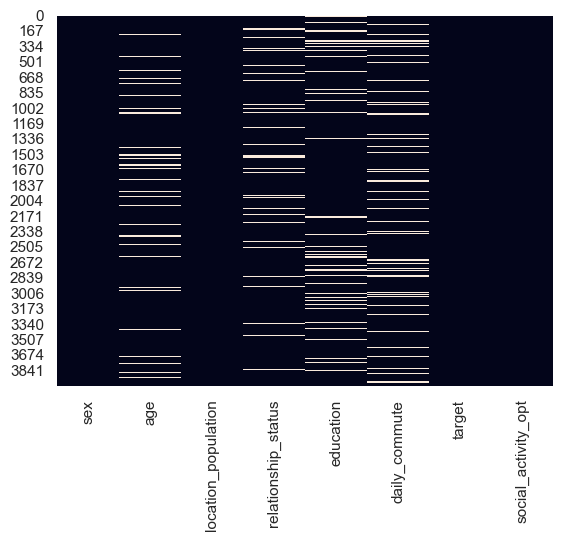

sex                       2
age                     191
location_population       0
relationship_status     230
education               183
daily_commute           204
target                 2000
social_activity_opt       0
dtype: int64




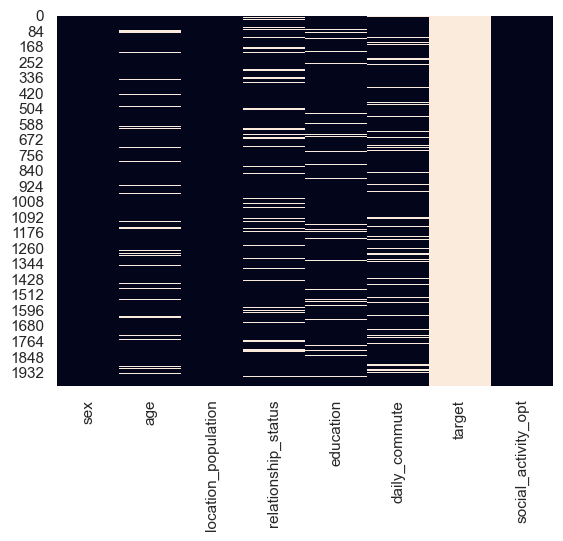

In [21]:
for df in dfs:
    # check for missing values
    print(df.isnull().sum())
    print("\n")

    # visualize the missing data using a heatmap
    # correlations between missing values can be further investigated by creating and visualizaing a correlation matrix for columns with missing values
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

Two groups of features are observed in both the training and the test dataset. Features in the first one have no missing values, while in the other one have around 10% of missing values. The missing values are distrubted randomly, there are no clear patterns such as data missing across all features for given users.

The datapoints with missing values are retained for further study by imputation methods (I use the most frequent value in each relevant column).

In [22]:
# impute the missing data
# ! relevant values should be determined using the entire dataset (train + test), but only the training one is used since feature distributions in both datasets are similar

# sex: use most frequent value
impute_sex = dfs[0]["sex"].mode()[0]
print(impute_sex)

# age: use most frequent value (age intervals)
impute_age = dfs[0]["age"].mode()[0]
print(impute_age)

# education: use most frequent value
impute_education = dfs[0]["education"].mode()[0]
print(impute_education)

# daily_commute: use most frequent value
impute_daily_commute = dfs[0]["daily_commute"].mode()[0]
print(impute_daily_commute)

# relationship_status: use most frequent value (categorical)
impute_relationship_status = dfs[0]["relationship_status"].mode()[0]
print(impute_relationship_status)

# apply to datasets
for df in dfs:
    df["sex"].fillna(impute_sex, inplace=True)
    df["age"].fillna(impute_age, inplace=True)
    df["education"].fillna(impute_education, inplace=True)
    df["daily_commute"].fillna(impute_daily_commute, inplace=True)
    df["relationship_status"].fillna(impute_relationship_status, inplace=True)
    

female
3.0
4.0
1.0
In relationship


C:\Users\malec\AppData\Local\Temp\ipykernel_33064\894887984.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sex"].fillna(impute_sex, inplace=True)
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\894887984.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age"].fillna(impute_age, inplace=True)
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\894887984.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["education"

The missing data issue is solved for both the training and the test datasets.

sex                    0
age                    0
location_population    0
relationship_status    0
education              0
daily_commute          0
target                 0
social_activity_opt    0
dtype: int64




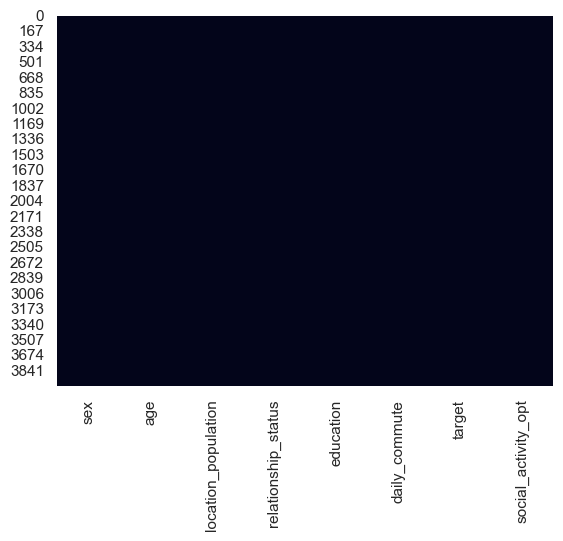

sex                       0
age                       0
location_population       0
relationship_status       0
education                 0
daily_commute             0
target                 2000
social_activity_opt       0
dtype: int64




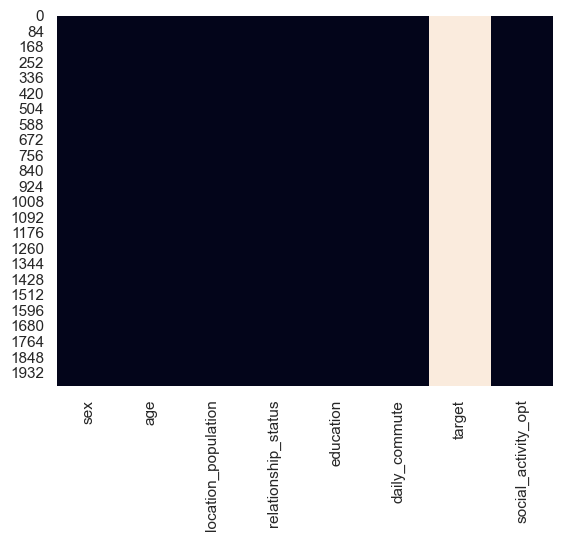

In [23]:
# final check

for df in dfs:
    # check for missing values
    print(df.isnull().sum())
    print("\n")

    # visualize the missing data using a heatmap
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

#### Feature normalization and encoding

I do not dedicate to features normalization for two reasons:

* all used features are categorical or ordinal (similar scales)
* chosen ML model (logistic regression) is fairly robust to feature scaling.

Feature normalization can be tested as part of experimenting phase.

I encode two categorical variables: "sex" and "relationship_status" using one-hot encoding.

In [24]:
# encode categorical data
# ? change encoding to keep flag for divorced

for i in range(len(dfs)):
    # use one-hot encoding
    dfs[i] = pd.get_dummies(data = dfs[i], drop_first = True) # drop_fist: encode n values using n-1 varaibles
    
    # rename columns for readability
    cols_mapping = {
        "relationship_status_In relationship": "relationship_in",
        "relationship_status_Married": "relationship_married",
        "relationship_status_Married with kids": "relationship_kids",
        "relationship_status_Single": "relationship_single"
    }
    dfs[i].rename(columns=cols_mapping, inplace=True)

for df in dfs:
    print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   4000 non-null   float64
 1   location_population   4000 non-null   int64  
 2   education             4000 non-null   float64
 3   daily_commute         4000 non-null   float64
 4   target                4000 non-null   int64  
 5   social_activity_opt   4000 non-null   int64  
 6   sex_male              4000 non-null   bool   
 7   relationship_in       4000 non-null   bool   
 8   relationship_married  4000 non-null   bool   
 9   relationship_kids     4000 non-null   bool   
 10  relationship_single   4000 non-null   bool   
dtypes: bool(5), float64(3), int64(3)
memory usage: 207.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  -

Some features show interesting correlations with the target variable, which is promising in terms of their predicitve capabilities. It is consistent with the observations from EDA.

I select all available features to train the model. It is possible to experiment later if tuning this selection can improve model performance.

The dataset is ready for model building.

In [25]:
# final check
# ! check datasets consistency after processing (train / test)

# check correlations between features and the target in the training dataset
correlations = dfs[0].corr().abs()
print(correlations["target"].sort_values(ascending=False).round(2))
print("\n")

# select final features for model building
# ! do not include the target variable
# ? experiment later (keep all for now)
features_final = dfs[0].columns.tolist()
features_final.remove("target")
# features_final = ['age', 'location_population', 'education', 'friends_number', 'daily_commute', 'sex_male', 'relationship_in', 'relationship_married', 'relationship_kids', 'relationship_single']

target                  1.00
relationship_single     0.32
social_activity_opt     0.30
relationship_kids       0.19
age                     0.18
sex_male                0.16
location_population     0.08
relationship_married    0.07
relationship_in         0.02
education               0.01
daily_commute           0.01
Name: target, dtype: float64




---
# 4. Model selection and training

## Model selection

I choose a logistic regression model due to its simplicity and interpretability. It is also a good baseline model. Decision tree or random forest methods could be explored at a later stage.

## Model training

I split the datasets into training, validation and test datasets. The test data (2k users) is originally provided by the client. I dedicate 20% of the original training sample (4k users) for the validation sample.

In [26]:
# split datasets into training / validation / test sets
# ! validation dataset for tuning the model and hold-out performance evaluation
# ? consider k-fold cross-validation

X = dfs[0][features_final]
y = dfs[0]["target"]

# split into training and validation datasets
# validation - 20% of original dataset / random_state: seed that ensures reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=275)

# prepare the test dataset
# ! keep in mind the target values are empty
X_test = dfs[1][features_final]
y_test = dfs[1]["target"]

The training dataset is used for building a baseline model.

In [27]:
# build the model
# ? hyperparameters optimization (tunining using validation dataset / grid search)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

I inspect the model coefficients.

These coeficients correspond to the significance of given feature in the prediction process. Observations are consistent with the outcomes of EDA (more discussion in section 'Findings').

In [28]:
# see model coefficients
coefficients_names = model.feature_names_in_
coefficients = model.coef_.round(3)[0]

# make a df for readability
coefficients_df = pd.DataFrame({"feature": coefficients_names, "coefficient": coefficients})
coefficients_df.loc[:, "coefficient_abs"] = coefficients_df["coefficient"].abs()

print(coefficients_df.sort_values("coefficient_abs", ascending=False))
print("\n")

                feature  coefficient  coefficient_abs
4   social_activity_opt        2.121            2.121
8     relationship_kids       -1.794            1.794
9   relationship_single        1.378            1.378
5              sex_male        0.703            0.703
7  relationship_married       -0.393            0.393
0                   age       -0.379            0.379
1   location_population        0.263            0.263
6       relationship_in       -0.053            0.053
3         daily_commute        0.023            0.023
2             education       -0.004            0.004




---
# 5. Model quality assessment

## Baseline

I use the trained logistic regression model as a baseline.

While precision is used as a success metric, I also inspect accuracy as a general performance benchmark.

Another reason to use the precision metrics is related to the presence of an unbalanced dataset.

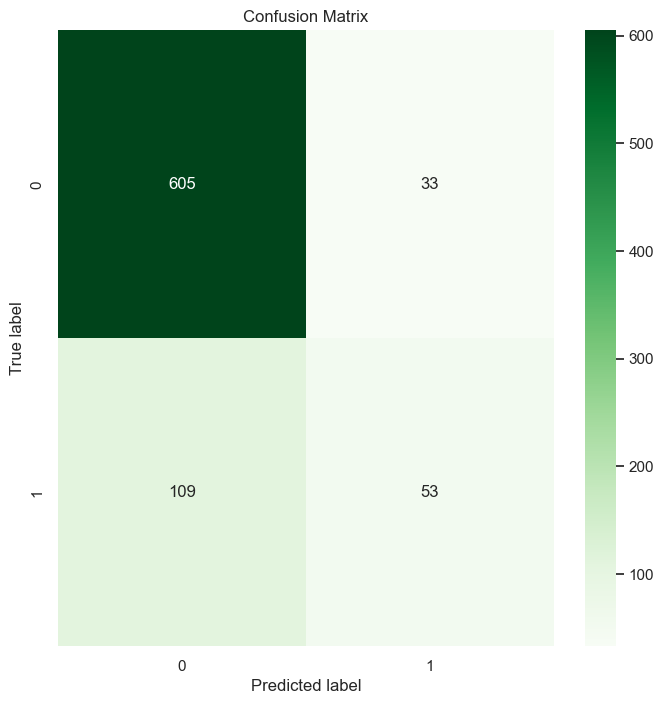

Accuracy:  0.82
Precision:  0.62




In [29]:
# baseline

# basic metrics
# ! use the validation dataset
y_pred = model.predict(X_val)

# confusion matrix for visualization
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# compute metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
# recall = recall_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred)

# print
print("Accuracy: ", accuracy.round(2))
print("Precision: ", precision.round(2))
# print("Recall: ", recall.round(2))
# print("F1 Score: ", f1.round(2))
print("\n")

## Experiments
 
Experimenting with other approaches can improve the performance of the model.

I try removing the least significant features from the training dataset ("education", "daily_commute").

The metrics are not significantly affected by this, so I keep the baseline model as the final one.

Other potential experiments and model tunings are listed in section 'Limitations of the Approach'.

In [30]:
# experiment: remove insignificant features
features_to_rm = ["education", "daily_commute"]

X_train_exp = X_train.copy().drop(features_to_rm, axis=1)
X_val_exp = X_val.copy().drop(features_to_rm, axis=1)

model_exp = LogisticRegression()
model_exp.fit(X_train_exp, y_train)

# basic metrics
# ! use the validation dataset
y_pred_exp = model_exp.predict(X_val_exp)

# compute metrics
accuracy_exp = accuracy_score(y_val, y_pred_exp)
precision_exp = precision_score(y_val, y_pred_exp)

# print
print("Accuracy: ", accuracy_exp.round(2))
print("Precision: ", precision_exp.round(2))
print("\n")



Accuracy:  0.82
Precision:  0.61




## QA summary and final test predictions

The logistic regression model performs reasonably well for this use-case of idenifying main propensity drivers. The significance of various features (reflected in model coefficients) is consistent with the observations from the EDA, which additionaly supports the model validity.

The model simplicity enables meaningful interpretation of the model predictions (more in section 'Findings').

I use the current model to score the test file.

In [31]:
# score test and create output in relevant format
probabilities = model.predict_proba(X_test)[:, 1]
labels = model.predict(X_test)

# prepare a df in format: user_id,probability_of_one,target
df_out = df_test[["user_id"]]
df_out.loc[:, "probability_of_one"] = probabilities.round(3)
df_out.loc[:, "target"] = labels

# save to csv
df_out.to_csv("data/output.csv", index=False, float_format="%.3f")

C:\Users\malec\AppData\Local\Temp\ipykernel_33064\2683410014.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.loc[:, "probability_of_one"] = probabilities.round(3)
C:\Users\malec\AppData\Local\Temp\ipykernel_33064\2683410014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.loc[:, "target"] = labels


---
## 6. Findings and recommendations

A simple logistic regression model seems sufficient to predict the user propensity for climbing wall subscription. Its interpretability allows to determine key propensity drivers and provide actionable insights.

The model coefficients correspond to the feature significance in propensity prediction, and I identify the patterns below.

Key positive propensity drivers are:
* users social activity ('optimal' number of friends)
* being single
* being male
* location population.

On the other hand, the following factors have a negative impact on user propensity:
* having kids
* being married
* higher age.

Combining this with the information from EDA.
* In the group with 'optimal' social activity (between 100-250 friends) there were 30% potential users (compared to 6% in the remaining group).
* Being single is a strong predictor for subscription (50% people in this group declare interest in long-term subscription).
* Also males declare interest in subscription two times more freqently than females.
* In group of users from big cities (500k+), the fraction of potential subscribers is around 50% higher than in locations with smaller population (27% in big cities VS 18% in other locations). 

I identify the profile of users with high propensity scores as someone with 'optimal' social activity, single, male, and living in a big city. The higher propensity in big cities is further enhanced (in terms of potential benefits) by high population potential, so I recommend taking the approach below.
* Consider locations in 500k+ cities, which correspond to: Warszawa, Krakow, Wroclaw, Lodz, Poznan.
* Focus on districts which are preferred by people with the profile identified above. Perform local market research or gather more sociodemographical data for these regions if needed.

In [32]:
# see model coefficients
coefficients_names = model.feature_names_in_
coefficients = model.coef_.round(3)[0]

# make a df for readability
coefficients_df = pd.DataFrame({"feature": coefficients_names, "coefficient": coefficients})
coefficients_df.loc[:, "coefficient_abs"] = coefficients_df["coefficient"].abs()

print(coefficients_df.sort_values("coefficient_abs", ascending=False))
print("\n")

                feature  coefficient  coefficient_abs
4   social_activity_opt        2.121            2.121
8     relationship_kids       -1.794            1.794
9   relationship_single        1.378            1.378
5              sex_male        0.703            0.703
7  relationship_married       -0.393            0.393
0                   age       -0.379            0.379
1   location_population        0.263            0.263
6       relationship_in       -0.053            0.053
3         daily_commute        0.023            0.023
2             education       -0.004            0.004




---
# 7. Limitations of the approach

## Limitations
* The performance of current method (logistic regression) is limited by susceptibility to unbalanced datasets, as well as inability to reproduce non-linear relationships. Decision trees or random forest methods can be explored to mitigate these effects.
* The current approach using Jupyter notebooks is not easily scalable. The code would benefit from refactoring to facilitate potential deployment phase.

## Perspectives
* Try K-fold cross-validation.
* Improve imputation methods.
* Experiment with feature normalization.
* Hyperparameters optimization / grid search.
* Threshold optimization (and ROC-AUC).

## Assumptions
* Current year 2024 is assumed (age calculation).

---
# 8. Extras

## Experiment: cross-validation

In [33]:
# cross-validation
# ! keep the test dataset / k-folds = 5
# ? check "accuracy" / "precision"

from sklearn.model_selection import cross_validate

# perform cross-validation
score_cv = cross_validate(model, X, y, cv=5, scoring=("accuracy", "precision"), n_jobs=-1)

# print summary
print(f"Accuracy (mean): {score_cv['test_accuracy'].mean():.2f}")
print(f"Precision (mean): {score_cv['test_precision'].mean():.2f}")
print("\n")

Accuracy (mean): 0.83
Precision (mean): 0.65




## Experiment: decision tree

In [34]:
# create a tree
model_tree = DecisionTreeClassifier(criterion = "gini", max_depth = 3, random_state = 24)
model_tree.fit(X_train, y_train)

# validation
y_pred_tree = model_tree.predict(X_val)

# compute metrics
accuracy_tree = accuracy_score(y_val, y_pred_tree)
precision_tree = precision_score(y_val, y_pred_tree)

# print
print("Accuracy: ", accuracy_tree.round(2))
print("Precision: ", precision_tree.round(2))
print("\n")

Accuracy:  0.81
Precision:  0.58




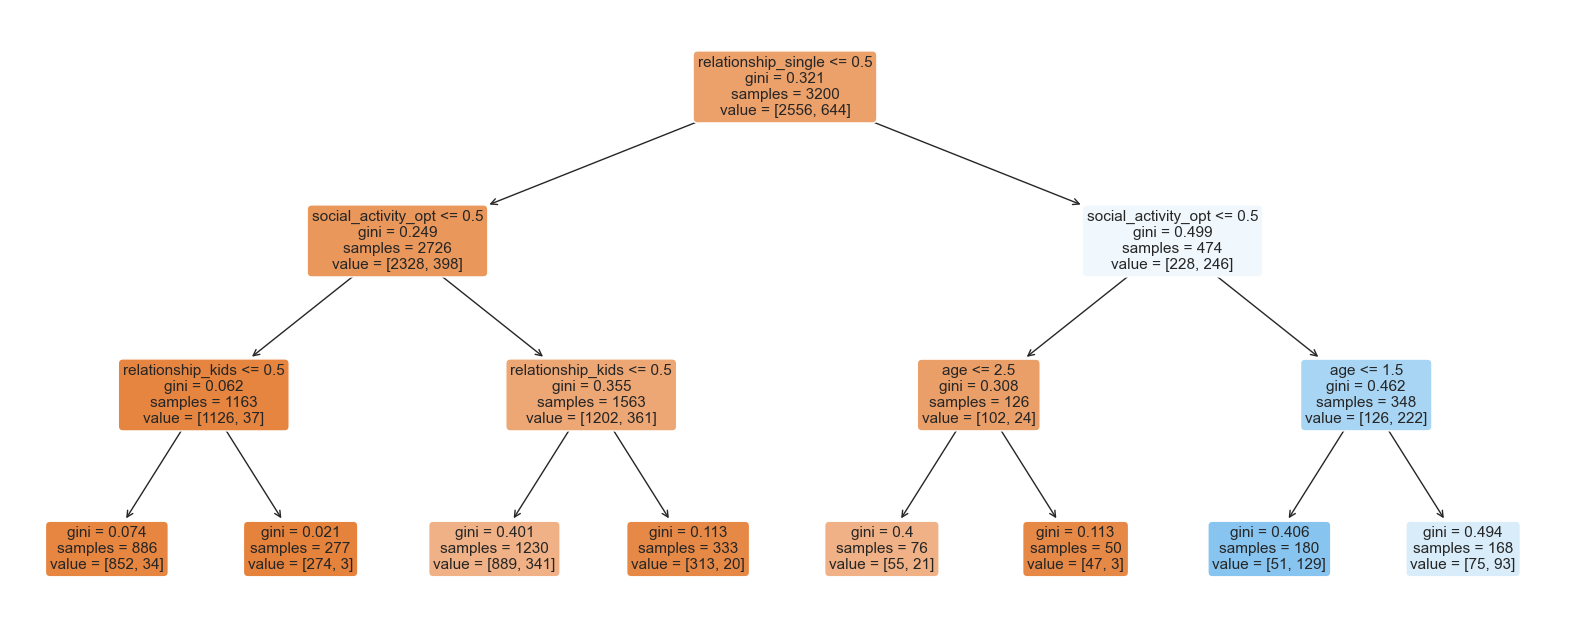

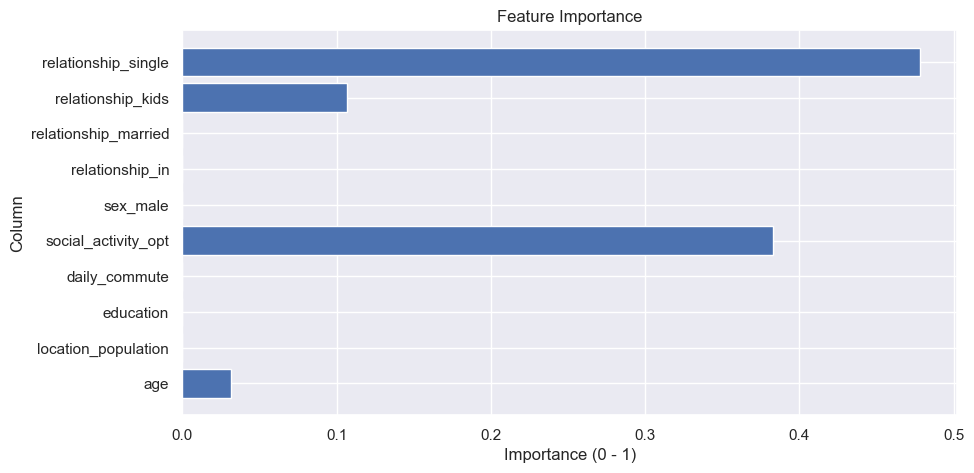

In [35]:
# interpretation (visualization)
plt.figure(figsize = [20.0, 8.0])
_ = plot_tree(model_tree, 
    feature_names = X_train.columns.to_list(),
    filled = True,       
    proportion = False,
    precision = 3,
    rounded = True,
    fontsize = 11)

plt.show()

# interpretation (feature importance)
plt.figure(figsize = [10.0, 5.0])

plt.barh(model_tree.feature_names_in_, model_tree.feature_importances_)
plt.xlabel("Importance (0 - 1)")
plt.ylabel("Column")
plt.title("Feature Importance")

plt.show()

## Experiment: random forest

In [36]:
# create a random forest
# ? oob_score (no need to split datasets)
model_forest = RandomForestClassifier(n_estimators=100, max_depth = 3, random_state = 14, n_jobs = -1)
model_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=14)

In [37]:
# validation
y_pred_forest = model_forest.predict(X_val)

# compute metrics
accuracy_forest = accuracy_score(y_val, y_pred_forest)
precision_forest = precision_score(y_val, y_pred_forest)

# print
print("Accuracy: ", accuracy_forest.round(2))
print("Precision: ", precision_forest.round(2))
print("\n")

Accuracy:  0.82
Precision:  0.74




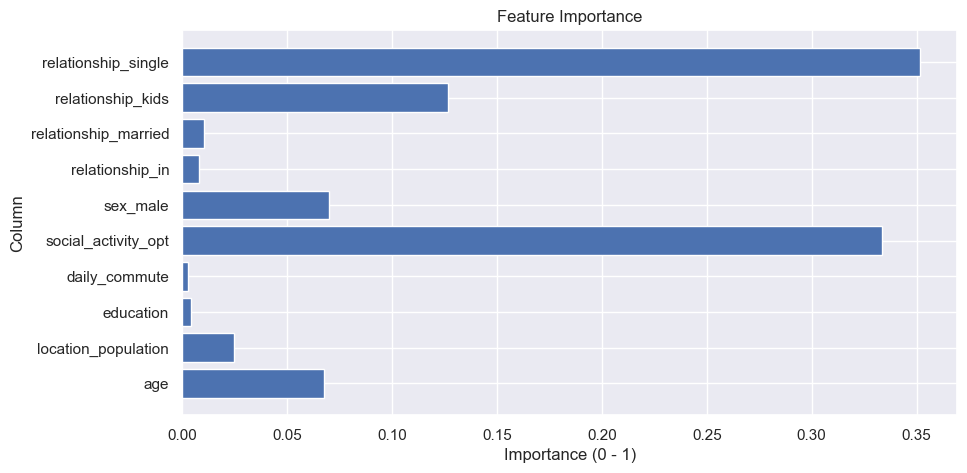

In [38]:
# interpretation (feature importance)
plt.figure(figsize = [10.0, 5.0])

plt.barh(model_forest.feature_names_in_, model_forest.feature_importances_)
plt.xlabel("Importance (0 - 1)")
plt.ylabel("Column")
plt.title("Feature Importance")

plt.show()